# Data Pre-Processing

**Import Packages and Data**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [2]:
# create dataframe
df = pd.read_csv("data/healthcare-dataset-stroke-data.csv")

In [3]:
# check shape of dataset
print(df.shape)

(5110, 12)


In [4]:
# first 5 rows of dataset
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Data Cleaning

### Check Null Values

In [5]:
# features with nan value
features_with_na = [column for column in df.columns if df[column].isnull().sum() >= 1]
for feature in features_with_na:
    print(feature, np.round(df[feature].isnull().mean()*100, 5), "% missing values")

bmi 3.93346 % missing values


**Why might a value be missing?**

When considering the potential impact of the missing data on the dataset, it is important to consider the underlying reasons for why the data are missing. We can divide the missing data into 3 categories:
* Missing Completely At Random (MCAR)
* Missing At Random (MAR)
* Missing Not At Random (MNAR)

In our case, it is MCAR type of missing values in the dataset. When we make this assumption, we are assuming the missing data is completely unrelated to the other information in the data.

### Check Duplicate Values

In [6]:
df.duplicated().sum()

0

### Remove "id" from the dataset & "gender", "Residence_type" from the dataset as per EDA report

In [7]:
df.drop(["id", "gender", "Residence_type"], inplace=True, axis=1)

## Feature Engineering

#### Types of Features

**Numeric Features**

In [8]:
numeric_features = [column for column in df.columns if df[column].dtype != 'O']
print("Number of Numerical Features:", len(numeric_features))
numeric_features

Number of Numerical Features: 6


['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']

**Categorical Features**

In [9]:
categorical_features = [column for column in df.columns if df[column].dtype == 'O']
print("Number of Categorical Features:", len(categorical_features))
categorical_features

Number of Categorical Features: 3


['ever_married', 'work_type', 'smoking_status']

**Discrete Features**

In [10]:
discrete_features = [feature for feature in numeric_features if (len(df[feature].unique())<=25)]
print("Number of Discrete Features:", len(discrete_features))
discrete_features

Number of Discrete Features: 3


['hypertension', 'heart_disease', 'stroke']

**Continuous Features**

In [11]:
continuous_features = [feature for feature in numeric_features if len(df[feature].unique()) > 25]
print("Number of Continuous Features: ", len(continuous_features))
continuous_features

Number of Continuous Features:  3


['age', 'avg_glucose_level', 'bmi']

#### Impute Null Values with Median value

* As the distribution of 

In [12]:
# create copy of dataframe & impute null values with median value
df1 = df.copy()
for feature in continuous_features:
    df1[feature].fillna(df1[feature].median(), inplace=True)

#### Multicollinearity Check

**Variance Inflation Factor (VIF)**

* Multicollinearity occurs when there are two or more independent variables having high correlation among themselves.
* Multicollinearity can be detected using various techniques, one such technique being the Variance Inflation Factor (VIF).

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(considered_features, df):
    """
    Compute the Variance Inflation Factor (VIF) for a set of features in a DataFrame.

    The Variance Inflation Factor quantifies the severity of multicollinearity in 
    a regression analysis by measuring how much the variance of a regression 
    coefficient is inflated due to multicollinearity with other features.

    Parameters:
    ----------
    considered_features : list of str
        The list of column names (features) from the DataFrame for which VIF 
        should be computed.
    
    df : pandas DataFrame
        The DataFrame containing the features.

    Returns:
    -------
    vif : pandas DataFrame
        A DataFrame containing the VIF values for each feature, with two columns:
        "Variable" for the feature names and "VIF" for their corresponding VIF values.
    """
    X = df[considered_features]
    # the calculation of variance inflation requires a constant
    X["intercept"] = 1

    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif["Variable"] != "intercept"]
    return vif

In [14]:
compute_vif(continuous_features, df1)

,Variable,VIF
0,age,1.162810
1,avg_glucose_level,1.070325
2,bmi,1.128268


* VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable.
* VIF above 5 is an indicator of Multicollinearity.

In our case, there is no multicollinearity.

#### Handle Outliers

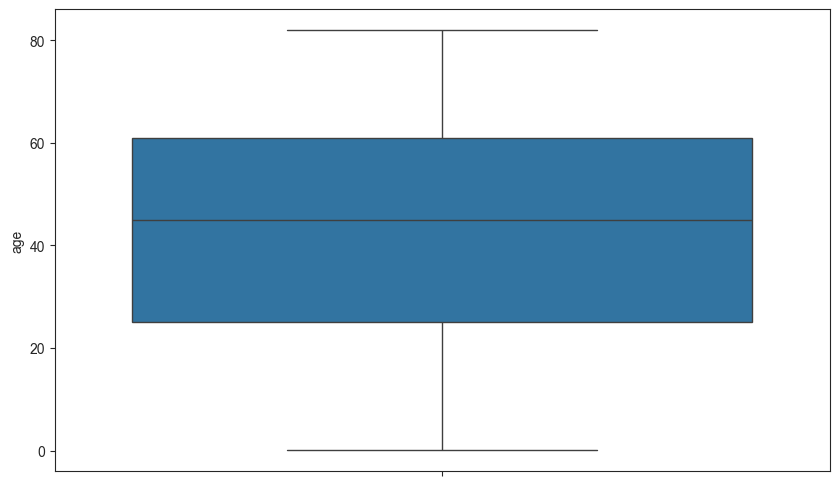

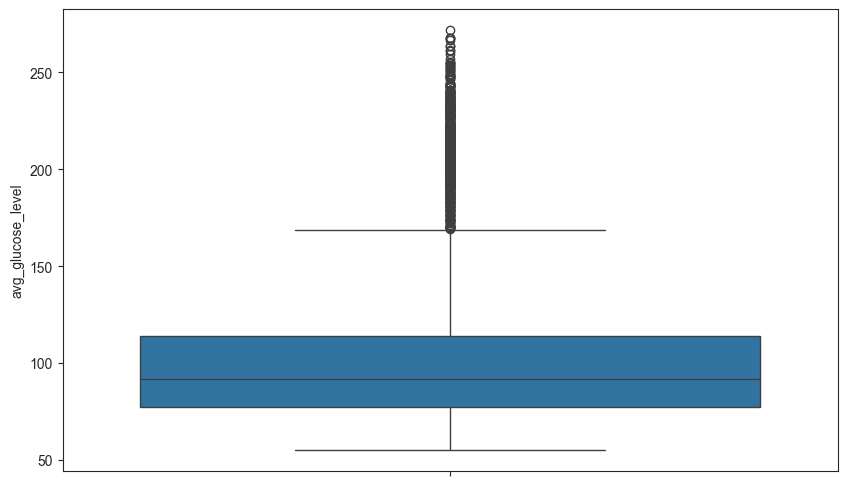

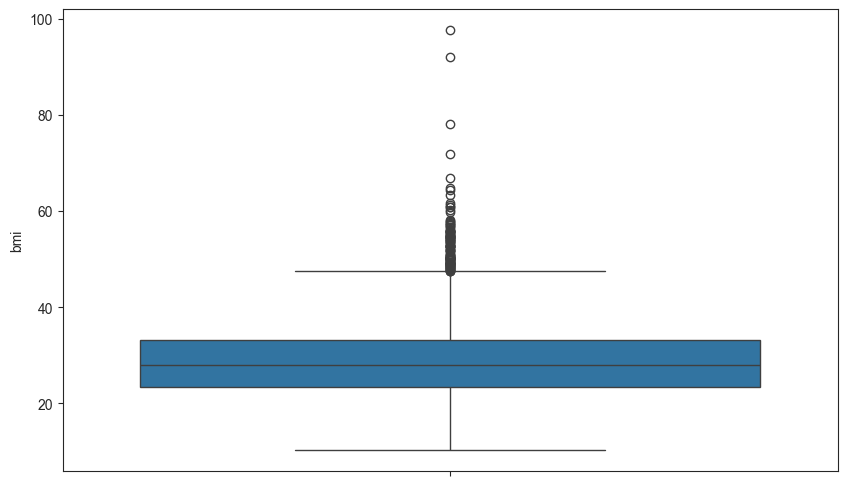

In [15]:
for i in continuous_features:
    plt.figure(figsize=(10, 6))
    sns.set_style("ticks")
    ax = sns.boxplot(df[i])

**Outlier removal using standard deviation procedure**

* Usually z-score = 3 is considered as a cut-off value to set the limit. Any z-score greater than +3 or less than -3 is considered as outlier which ispretty much similar to standard deviation method.
* Here we can remove outliers after 3rd standard deviation or z-score +3 and -3.

In [16]:
def outlier_removal(column, df):
    upper_limit = df[column].mean() + 3*df[column].std()
    lower_limit = df[column].mean() - 3*df[column].std()
    df = df[(df[column] < upper_limit) & (df[column] > lower_limit)]
    return df

In [17]:
df.shape

(5110, 9)

In [18]:
outlier_feature = ["bmi"]

In [19]:
for i in range(len(outlier_feature)):
    df = outlier_removal(outlier_feature[i], df)

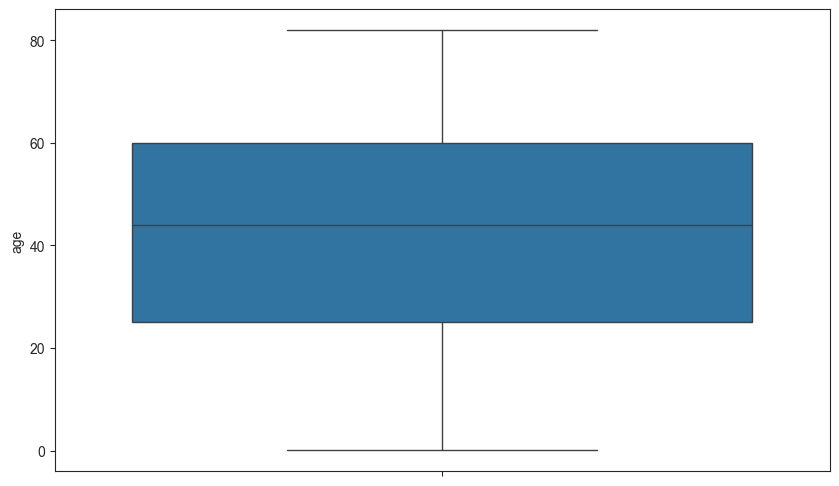

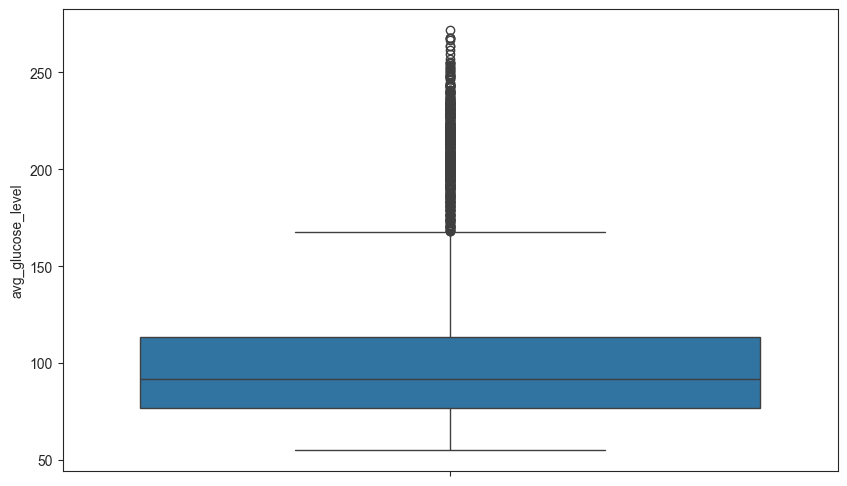

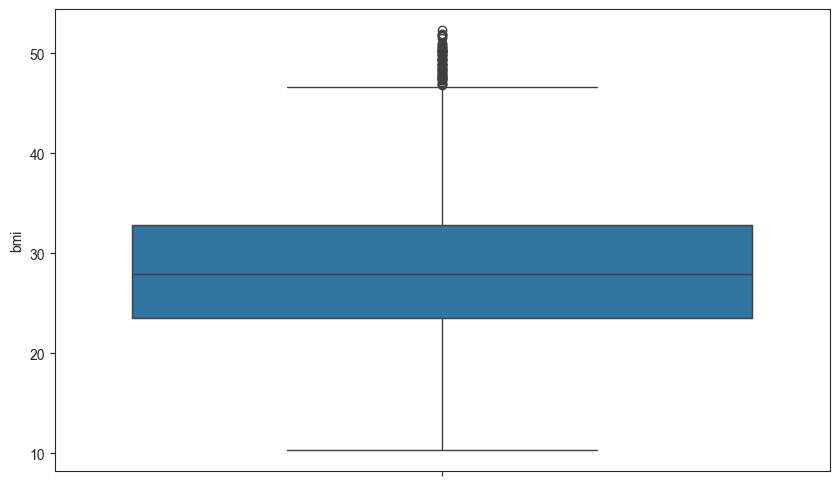

In [20]:
for i in continuous_features:
    plt.figure(figsize=(10, 6))
    sns.set_style("ticks")
    ax = sns.boxplot(df[i])

In [21]:
df.shape

(4851, 9)

#### Feature Transformation

* If Skewness is above 2, then the feature is Highly skewed.
* If Skewness is above 1.5, then the feature is moderately skewed.

In [22]:
df[continuous_features].skew(axis=0)

age                 -0.115593
avg_glucose_level    1.626970
bmi                  0.466922
dtype: float64

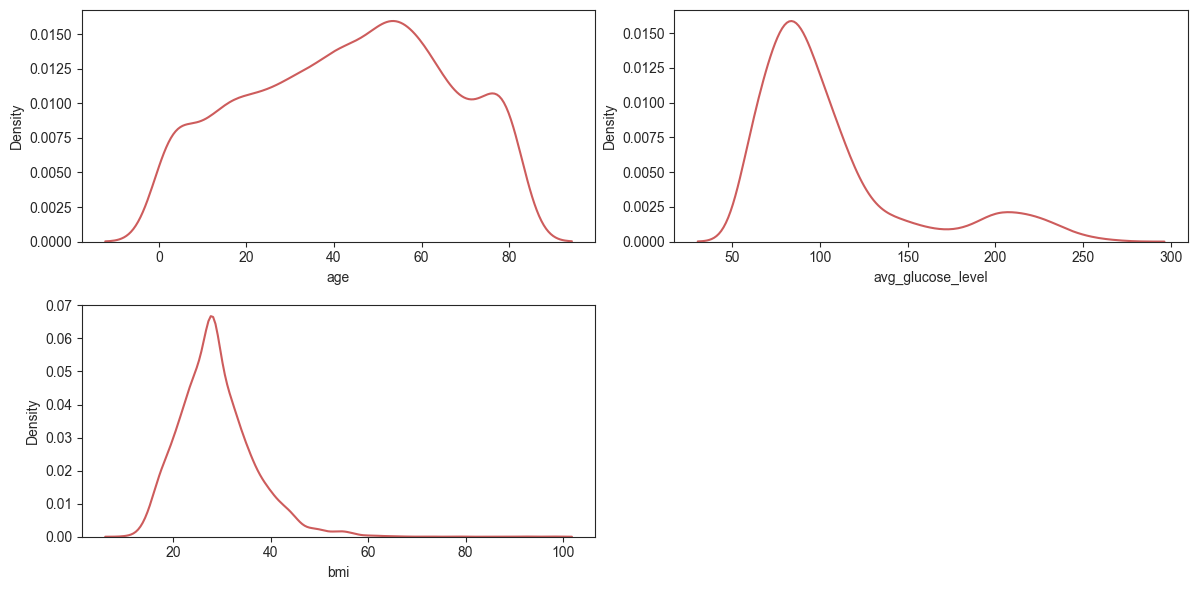

In [23]:
# distribution of data before scaling
plt.figure(figsize=(12, 6))
for i, col in enumerate(continuous_features):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(x=df1[col], color="indianred")
    plt.xlabel(col)
    plt.tight_layout()

* `avg_glucose_level` is slightly skewed.
* `age` has kutosis and it is platykurtic.
* `bmi` is normally distributed with very little data on its tails.

#### Split X and y

In [24]:
from sklearn.model_selection import train_test_split
X = df.drop(["stroke"], axis=1)
y = df["stroke"]

In [25]:
for feature in categorical_features:
    print(feature, ":", X[feature].nunique())

ever_married : 2
work_type : 5
smoking_status : 4


#### Feature Encoding and Scaling

**One Hot Encoding for columns having lesser unique values and non-ordinal in nature:**

In [26]:
for i in continuous_features:
    print(f"{i}: mean = {df[i].mean():.2f}, median = {df[i].median():.2f}")

age: mean = 42.83, median = 44.00
avg_glucose_level: mean = 105.10, median = 91.68
bmi: mean = 28.54, median = 27.90


* **Mean Imputer:** There are no missing values in `age` and `avg_glucose_level` and only `bmi` column should be handled. Based on the above result we can impute the column with either mean or median. Since we handled outlier for the continuous features, the mean and median of the features are nearly same. When there are no outliers mean will perform as a better imputer.
* **Standardscaler:** As most of our features are near normally distributed, we will perform standard scaling to scale the data.
* **Power Transformer:** Since `avg_glucose_level` was right skewed, we will use Power Transformer to transform it.

In [27]:
# create column Transformer with 3 types of transformers
categorical_features = X.select_dtypes(include="object").columns
num_feature = numeric_features.copy()
num_feature.remove("stroke")
transform_features = ["avg_glucose_level"]

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numeric_pipeline = Pipeline(steps=[("imputer", SimpleImputer(strategy="mean")),
                                   ("scaler", StandardScaler())])

categorical_pipeline = Pipeline(steps=[("one_hot_encoder", OneHotEncoder()),
                                       ("scaler", StandardScaler(with_mean=False))])

transform_pipe = Pipeline(steps=[("transformer", PowerTransformer(standardize=True))])

preprocessor = ColumnTransformer([("numeric_Pipeline", numeric_pipeline, num_feature),
                                  ("categorical_Pipeline", categorical_pipeline, categorical_features),
                                  ("Power_Transformation", transform_pipe, transform_features)])

In [28]:
X = preprocessor.fit_transform(X)

#### Handle Imbalanced Data

* We will handle the imbalanced Target Variable.
* Synthetic Minority Oversampling Technique or SMOTE is another technique to oversample the minority class. Simply adding duplicate records or minority class often don't add any new information to the model.
* SMOTE is one of the famous oversampling techniques and is very effective in handling class imbalance. The idea is to combine SMOTE with some undersampling techniques (ENN, Tomek) to increase the effectiveness of handling the imbalanced class.

`SMOTE+ENN` is one of such hybrid technique that aims to clean overlapping data points for each of the classes distributed in sample space. This method combines the SMOTE ability to generate synthetic data for minority class and uses ENN to remove overlapping observation of both the classes.

**To add new data of minority class**
1. Choose random data from the minority class.
2. Calculate the distance between the random data and its k nearest neighbors.
3. Multiply the difference with a random number between 0 and 1, then add the result to the minority class as a synthetic sample.
4. Repeat step number 2-3 until the desired proportion of minority class is met.

**To remove the data points of both classes**
1. Determine K, as the number of nearest neighbors. If not determined, then K=3.
2. Find the K-nearest neighbor of the observation among the other observations in the dataset, then return the majority class from the K-nearest neighbor.
3. If the class of the observation and the majority class from the observation's K-nearest neighbor is difficult, then the observation and its K-nearest neighbor are deleted from the dataset.
4. Repeat step 2 and 3 until the desired proportion of each class is fulfilled.

* This method, instead of adding duplicate data, synthesises the new data based on the already available classes. Hence, we choose this as our imputer method for this problem.

In [29]:
from imblearn.combine import SMOTEENN

# Resampling the minority class. The strategy can be changed as required
smt = SMOTEENN(random_state=42, sampling_strategy="minority")
# fit the model to generate the data
X_res, y_res = smt.fit_resample(X, y)

### Model Selection

Out of various classification models, we will choose top 3 with highest Accuracy score and proceed with Hyperparameter Tuning.

##### Train Test Split

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [31]:
def evaluate_clf(true, predicted):
    """
    Evaluate the performance of a classification model.

    This function calculates and returns various performance metrics for a 
    classification model based on the true labels and the predicted labels.

    Parameters:
    ----------
    true : array-like
        The ground truth (correct) target values.
    
    predicted : array-like
        The estimated targets as returned by a classifier.

    Returns:
    -------
    acc : float
        Accuracy of the model, defined as the ratio of correctly predicted
        instances to the total instances.
    
    f1 : float
        F1 score of the model, which is the harmonic mean of precision and recall.
    
    precision : float
        Precision of the model, which is the ratio of true positive predictions
        to the total predicted positives.
    
    recall : float
        Recall of the model, which is the ratio of true positive predictions
        to the total actual positives.
    
    roc_auc : float
        ROC AUC (Area Under the Receiver Operating Characteristic Curve) score,
        which provides an aggregate measure of performance across all classification
        thresholds.
    """
    acc = accuracy_score(true, predicted) # calculate accuracy
    f1 = f1_score(true, predicted) # calculate f1-score
    precision = precision_score(true, predicted) # calculate precision
    recall = recall_score(true, predicted) # calculate recall
    roc_auc = roc_auc_score(true, predicted) # calculate ROC
    return acc, f1, precision, recall, roc_auc

In [32]:
# initialize models
models = {"Decision Tree": DecisionTreeClassifier(),
          "Random Forest": RandomForestClassifier(),
          "Gradient Boosting": GradientBoostingClassifier(),
          "AdaBoost Classifier": AdaBoostClassifier(),
          "Logistic Regression": LogisticRegression(),
          "K-Neighbors Classifier": KNeighborsClassifier(),
          "SVM Classifier": SVC(),
          "XGBClassifier": XGBClassifier(),
          "CatBoost Classifier": CatBoostClassifier()}

In [33]:
# create a function which can evaluate models and return a report
def evaluate_models(X, y, models):
    """
    Evaluate multiple classification models and return a performance report.

    This function takes in features `X`, labels `y`, and a dictionary of models,
    splits the data into training and testing sets, trains each model, evaluates
    their performance on both sets, and returns a report containing accuracy scores.

    Parameters:
    ----------
    X : array-like or pandas DataFrame
        The feature set.
    
    y : array-like or pandas Series
        The target labels.
    
    models : dict
        A dictionary where the keys are model names (strings) and the values are
        model instances (objects). For example:
        {
            "Logistic Regression": LogisticRegression(),
            "Decision Tree": DecisionTreeClassifier(),
            ...
        }

    Returns:
    -------
    pd.DataFrame
        A pandas DataFrame containing the model names and their corresponding
        accuracy scores on the test set, sorted by accuracy in descending order.
        The DataFrame has two columns: "Model Name" and "Accuracy".
    """
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models_list = []
    accuracy_list = []
    acc = []

    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # train model

        # make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1, model_train_precision, model_train_recall, model_train_rocauc_score = evaluate_clf(y_train, y_train_pred)

        # Test set performance
        model_test_accuracy, model_test_f1, model_test_precision, model_test_recall, model_test_rocauc_score = evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print("Model performance for Training set")
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print("- F1 score: {:.4f}".format(model_train_f1))
        print("- Precision: {:.4f}".format(model_train_precision))
        print("- Recall: {:.4f}".format(model_train_recall))
        print("- ROC AUC Score: {:.4f}".format(model_train_rocauc_score))

        print("------------------------------------")

        print("Model performance for Test set")
        print("- Accuracy: {:.4f}".format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print("- F1 score: {:.4f}".format(model_test_f1))
        print("- Precision: {:.4f}".format(model_test_precision))
        print("- Recall: {:.4f}".format(model_test_recall))
        print("- ROC AUC Score: {:.4f}".format(model_test_rocauc_score))
        acc.append(model_test_rocauc_score)
        print("="*35)
        print("\n")
    
    report = pd.DataFrame(list(zip(models_list, accuracy_list)), columns=["Model Name", "Accuracy"]).sort_values(by=["Accuracy"], ascending=False)

    return report

### Evaluate all base models

In [34]:
base_report = evaluate_models(X=X_res, y=y_res, models=models)
base_report

Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- ROC AUC Score: 1.0000
------------------------------------
Model performance for Test set
- Accuracy: 0.9348
- F1 score: 0.9379
- Precision: 0.9284
- Recall: 0.9476
- ROC AUC Score: 0.9342


Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- ROC AUC Score: 1.0000
------------------------------------
Model performance for Test set
- Accuracy: 0.9823
- F1 score: 0.9831
- Precision: 0.9726
- Recall: 0.9939
- ROC AUC Score: 0.9818


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9247
- F1 score: 0.9301
- Precision: 0.9107
- Recall: 0.9504
- ROC AUC Score: 0.9233
------------------------------------
Model performance for Test set
- Accuracy: 0.9088
- F1 score: 0.9156
- Precision: 0.8825
- Recall: 0.9513
- ROC AUC Score: 0.9070


AdaBoost Classifier
Model performance for Tra

,Model Name,Accuracy
1,Random Forest,0.982267
7,XGBClassifier,0.973401
5,K-Neighbors Classifier,0.972134
8,CatBoost Classifier,0.965801
0,Decision Tree,0.934769
6,SVM Classifier,0.920836
2,Gradient Boosting,0.908803
3,AdaBoost Classifier,0.877137
4,Logistic Regression,0.858771


Hence our Top 3 base models are: **Random Forest**, **XGBClassifier** & **K-Neighbors Classifier**.

#### Hyperparameter Tuning

In [35]:
# initialize few parameter for Hyperparameter tuning
xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8, 12, 20, 30],
                  "n_estimators": [100, 200, 300],
                  "colsample_bylevel": [0.5, 0.8, 1, 0.3, 0.4]}

rf_params = {"max_depth": [10, 12, None, 15],
             "max_features": ['sqrt', 'log2', None],
             "min_samples_split": [100, 150, 200, 300],
             "n_estimators": [10, 50, 100, 200]}

knn_params = {"algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
              "weights": ["uniform", "distance"],
              "n_neighbors": [3, 4, 5, 7, 9]}

In [36]:
# model list for hyperparameter tuning
randomcv_models = [("XGBoost", XGBClassifier(), xgboost_params),
                   ("RF", RandomForestClassifier(), rf_params),
                   ("KNN", KNeighborsClassifier(), knn_params)]

In [37]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                param_distributions=params,
                                n_iter=100,
                                cv=3,
                                verbose=2,
                                n_jobs=-1)
    
    random.fit(X_res, y_res)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"-------------------- Best Params for {model_name} ----------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[CV] END colsample_bylevel=0.8, learning_rate=0.1, max_depth=8, n_estimators=300; total time=   0.5s
[CV] END colsample_bylevel=0.8, learning_rate=0.1, max_depth=8, n_estimators=300; total time=   0.5s
[CV] END colsample_bylevel=0.8, learning_rate=0.1, max_depth=8, n_estimators=300; total time=   0.5s
[CV] END colsample_bylevel=0.8, learning_rate=0.1, max_depth=20, n_estimators=200; total time=   0.5s
[CV] END colsample_bylevel=0.8, learning_rate=0.1, max_depth=20, n_estimators=200; total time=   0.6s
[CV] END colsample_bylevel=0.8, learning_rate=0.1, max_depth=20, n_estimators=200; total time=   0.6s
[CV] END colsample_bylevel=0.4, learning_rate=0.01, max_depth=8, n_estimators=100; total time=   0.2s
[CV] END colsample_bylevel=0.3, learning_rate=0.01, max_depth=30, n_estimators=200; total time=   0.8s
[CV] END colsample_bylevel=0.4, learning_rate=0.01, max_depth=8, n_estimators=100; total time=   0.2s
[CV] END colsample_bylevel=0.4, learning_rate=0.01, max_depth=8, n_estimators=100; t

#### Retraining the Model with best parameters

In [38]:
best_models = {"Random Forest Classifier": RandomForestClassifier(**model_param["RF"]),
               "KNeighborsClassifier": KNeighborsClassifier(**model_param["KNN"]),
               "XGBClassifier": XGBClassifier(**model_param["XGBoost"], n_jobs=-1)}

tuned_report = evaluate_models(X=X_res, y=y_res, models=best_models)

Random Forest Classifier
Model performance for Training set
- Accuracy: 0.9300
- F1 score: 0.9352
- Precision: 0.9127
- Recall: 0.9588
- ROC AUC Score: 0.9283
------------------------------------
Model performance for Test set
- Accuracy: 0.9170
- F1 score: 0.9226
- Precision: 0.8956
- Recall: 0.9513
- ROC AUC Score: 0.9156


KNeighborsClassifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- ROC AUC Score: 1.0000
------------------------------------
Model performance for Test set
- Accuracy: 0.9848
- F1 score: 0.9856
- Precision: 0.9716
- Recall: 1.0000
- ROC AUC Score: 0.9842


XGBClassifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- ROC AUC Score: 1.0000
------------------------------------
Model performance for Test set
- Accuracy: 0.9778
- F1 score: 0.9790
- Precision: 0.9634
- Recall: 0.9951
- ROC AUC Score: 0.9771




In [39]:
tuned_report

,Model Name,Accuracy
1,KNeighborsClassifier,0.984801
2,XGBClassifier,0.977834
0,Random Forest Classifier,0.917036


#### Plot ROC AUC Curve

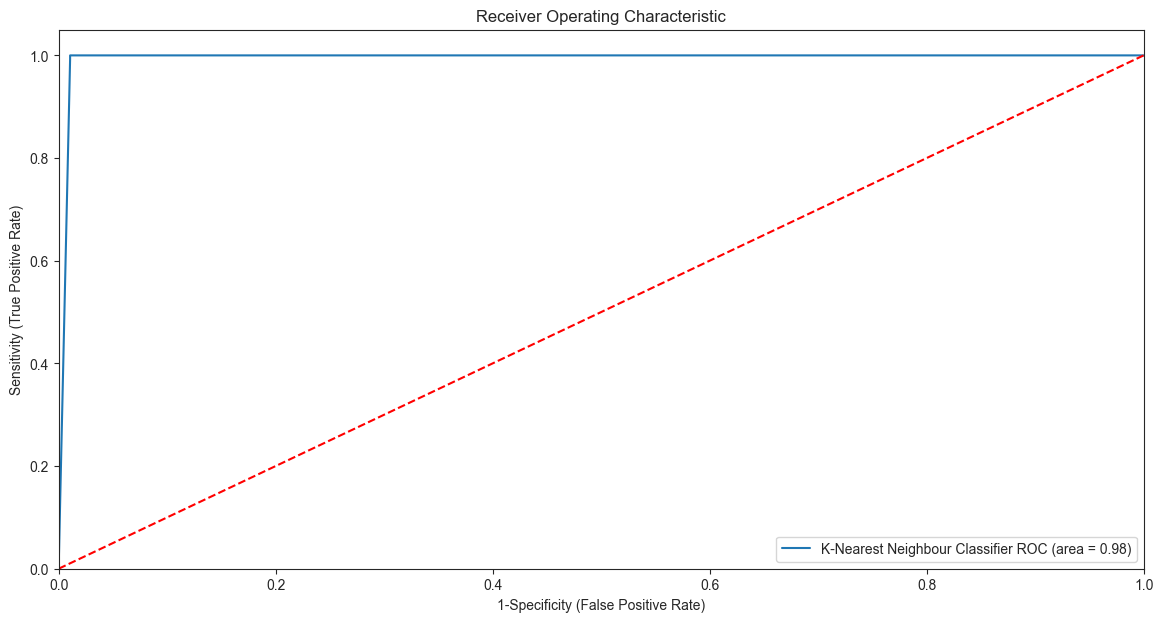

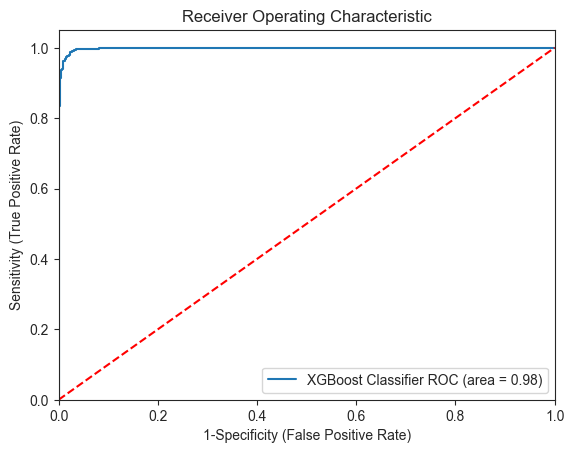

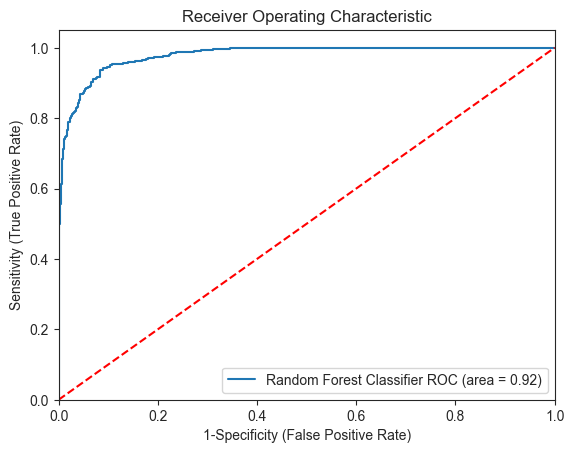

In [40]:
# add the models to the list to view the ROC plot
auc_models = [{"label": "K-Nearest Neighbour Classifier",
               "model": KNeighborsClassifier(**model_param["KNN"]),
               "auc": 0.984801},
               {"label": "XGBoost Classifier",
                "model": XGBClassifier(**model_param["XGBoost"], n_jobs=-1),
                "auc": 0.977834},
                {"label": "Random Forest Classifier",
                 "model": RandomForestClassifier(**model_param["RF"]),
                 "auc": 0.917036}]

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
# create loop through all model
plt.figure(figsize=(14, 7))
for algo in auc_models:
    model = algo["model"]
    model.fit(X_train, y_train)
    # compute True Positive Rate and False Positive Rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    # calculate Area Under the Curve to display on the plot
    plt.plot(fpr, tpr, label="%s ROC (area = %0.2f)" % (algo["label"], algo["auc"]))
    # custom settings for the plot
    plt.plot([0, 1], [0, 1], "r--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("1-Specificity (False Positive Rate)")
    plt.ylabel("Sensitivity (True Positive Rate)")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    # plt.savefig("images/auc.png")
    plt.show()

**KNN has performed well among other models.**


### Final Report

In [41]:
best_model = KNeighborsClassifier(**model_param["KNN"])
best_model = best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print("FINAL MODEL 'K-Nearest Neighbour'")
print("Accuracy Score: {:.4f}".format(score))
print(cr)

FINAL MODEL 'K-Nearest Neighbour'
Accuracy Score: 0.9848
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       758
           1       0.97      1.00      0.99       821

    accuracy                           0.98      1579
   macro avg       0.99      0.98      0.98      1579
weighted avg       0.99      0.98      0.98      1579



* The model achieves an accuracy score of 0.9848 (or 98.48%). This indicates that the model correctly predicted 98.48% of the test instances.
* **Precision**: The precision for class 0 is 1.00 and for class 1 is 0.97. Precision is the ratio of true positive predictions to the total predicted positives.
* **Recall**: The recall for class 0 is 0.97 and for class 1 is 1.00. Recall is the ratio of true positive predictions to the total actual positives.
* **F1-Score**: The f1-score for class 0 is 0.98 and for class 1 is 0.99. F1-score is the harmonic mean of precision and recall.
* **Support**: The number of actual occurrences of each class in the test set (758 for class 0 and 821 for class 1).
* **Overall Accuracy**: The overall accuracy is 0.98, consistent with the previously calculated accuracy score.
* **Macro Average**: The macro average (averaging the unweighted mean per label) for precision, recall, and f1-score is approximately 0.99, 0.98, and 0.98, respectively.
* **Weighted Average**: The weighted average (averaging the mean per label, weighted by support) for precision, recall, and f1-score is also approximately 0.99, 0.98, and 0.98, respectively.

##### Key Insights

1. **High Overall Performance**:
- The K-Nearest Neighbors classifier performs exceptionally well with an accuracy of 98.48%. This indicates that the model is highly effective in making correct predictions on the test set.

2. **Balanced Performance Across Classes**:
- Both classes (0 and 1) have high precision, recall, and f1-scores, suggesting that the model performs well across both classes without significant bias towards any class.

3. **Slight Variations in Class Performance**:
- Class 0 has a precision of 1.00, meaning it correctly identifies all instances predicted as class 0. However, its recall is slightly lower at 0.97, indicating some false negatives.
- Class 1 has a recall of 1.00, meaning it correctly identifies all actual instances of class 1, but its precision is slightly lower at 0.97, indicating some false positives.

4. **Robust Model**:
- The high f1-scores (0.98 for class 0 and 0.99 for class 1) reflect a good balance between precision and recall, highlighting the robustness of the model.

In summary, the K-Nearest Neighbors classifier is highly effective for the given dataset, demonstrating strong performance metrics and balanced classification capability across both classes.


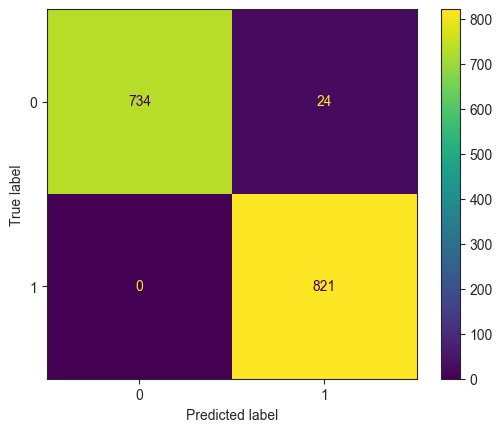

In [43]:
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.savefig('images/confusion_matrix.png')

The confusion matrix plot shows the performance of the K-Nearest Neighbors classifier (best_model) on the test set (X_test and y_test).

1. **True Positives (TP):** The number of true positive predictions.

* Bottom-right cell (yellow) indicates 821 instances of class 1 were correctly predicted as class 1.

2. **True Negatives (TN):** The number of true negative predictions.

* Top-left cell (light green) indicates 734 instances of class 0 were correctly predicted as class 0.

3. **False Positives (FP):** The number of false positive predictions.

* Top-right cell (dark purple) indicates 24 instances of class 0 were incorrectly predicted as class 1.

4. **False Negatives (FN):** The number of false negative predictions.

* Bottom-left cell (dark purple) indicates 0 instances of class 1 were incorrectly predicted as class 0.

#### Key Insights from the Confusion Matrix
1. **High True Positive and True Negative Rates:** The model correctly identifies 821 instances of class 1 and 734 instances of class 0, indicating high true positive and true negative rates.

2. **Low False Negative Rate:** The model has 0 false negatives, meaning it correctly identifies all actual instances of class 1.

3. **Moderate False Positive Rate:** There are 24 false positives, where the model incorrectly predicts class 0 instances as class 1. While this number is relatively low compared to the total instances, it indicates a potential area for improvement.

4. **Overall Performance:** The confusion matrix reflects the high accuracy score (0.9848 or 98.48%) and the strong classification metrics shown earlier, such as precision, recall, and f1-score.

5. **Balanced Classification:** The model shows a good balance in correctly predicting both classes, with a slight preference towards correctly predicting class 1 over class 0.

The confusion matrix confirms that the K-Nearest Neighbors classifier is highly effective for the given dataset. It achieves high true positive and true negative rates, with very low false negatives and moderate false positives. This reinforces the earlier analysis from the classification report, showcasing the model's robustness and high accuracy in predicting the classes correctly.

In [44]:
from sklearn.model_selection import cross_val_score

# loop over the models in the dictionary and perform cross-validation
for name, model in best_models.items():
    scores = cross_val_score(model, X_res, y_res, cv=5)
    print(f"{name} cross-validation scores: {scores}")
    print(f"Mean {name} cross-validation score: {scores.mean()}\n")

Random Forest Classifier cross-validation scores: [0.90753642 0.91444867 0.9207858  0.91381496 0.9157161 ]
Mean Random Forest Classifier cross-validation score: 0.9144603882870148

KNeighborsClassifier cross-validation scores: [0.98796707 0.98986058 0.98732573 0.9860583  0.98669202]
Mean KNeighborsClassifier cross-validation score: 0.987580739281652

XGBClassifier cross-validation scores: [0.97023433 0.9765526  0.98035488 0.98098859 0.98288973]
Mean XGBClassifier cross-validation score: 0.978204026067741



* All three models demonstrate high performance with cross-validation scores well above 90%. The KNeighborsClassifier has the highest mean cross-validation score, closely followed by the XGBClassifier, indicating that these models are particularly effective for the given dataset. The Random Forest Classifier, while slightly lower in accuracy, remains a strong contender with a consistent performance across different folds.

## KNN is the best model for this project.